In [1]:
import matplotlib.pyplot as plt
import mpl_toolkits.mplot3d
import numpy as np
import scipy.sparse as scps
import scipy.sparse.linalg as ssl
import math

In [2]:
def maillage_carre(n):
#
# Une discretisation possible d'une EDP elliptique sur le domaine ]0,1[ x ]0,1[
# Le carre [0,1]x[0,1] est maille uniquement avec des triangles; 
# Les conditions limites sont de type Dirichlet uniquement   => neumann  =[];
#
# Entrees :
# n : nombre de points par cote du care => Npts points de discretisation au
# total
#
# Sorties :
# coordinates : matrice a deux colonnes. Chaque ligne contient les 
# coordonnes 2D d'un des points de la discretisation. Ces sommets seront 
# identifies a l'indice de la ligne correspondante dans la matrice
# coordinates.
# elements3 : matrice a trois colonnes. Chaque ligne contient les indices 
# des sommets d'un element triangle, dans le sens antihoraire. 
# dirichlet : vecteur colonne des indices des sommets de la frontiere de
# Dirichlet.
# neumann : matrice a deux colonnes. Chaque ligne contient les indices 
# des deux sommets d'une arete de la frontiere de Neumann.
# (neumann est vide sur cet exemple)
#
##################################################################################
    h=1/(n-1)
    npoin       = n*n ; 
    nelem       = 2*(n-1)*(n-1) ;
    coordinates = np.zeros((npoin,2)); 
    elements3   = (np.zeros((nelem,3))).astype(int) ;
    neumann     = [];
    dirichlet=(np.zeros((4*n-4,1))).astype(int)
    # Coordonnees et connectivites :
    e = -1 ; 
    p = -1 ;
    x=np.zeros((n+1,1))
    x[n,0]=1.
    for l in range (n+1):
        x[l,0]=l*h
    for j in range (n):
            for i in range(n):
                p = p + 1  
                coordinates[p,0] = x[i,0]  
                coordinates[p,1] = x[j,0] 
                if ((i != n-1) & (j != n-1)):
                    p1 = p
                    p2 = p1 + 1 
                    p3 = p1 + n 
                    p4 = p2 + n 
                    e = e + 1 
                    elements3[e,0] = p1 
                    elements3[e,1] = p2 
                    elements3[e,2] = p3 
                    e = e + 1
                    elements3[e,0] = p4 
                    elements3[e,1] = p3 
                    elements3[e,2] = p2 
    #Liste des sommets de la frontiere de Dirichlet:
    p=-1
    for j in range(n):
        p=p+1
        dirichlet[p,0] = j  
    for j in range(n*2-1,n*(n-1),n):
        p=p+1
        dirichlet[p,0] = j 
    for j in range(n*n-1,n*n-n-1,-1):
        p=p+1
        dirichlet[p,0] = j 
    for j in range(n*n-2*n,n-1,-n):
        p=p+1
        dirichlet[p,0] = j 

    return coordinates, elements3,dirichlet, neumann

In [3]:
def show(coordinates,u):
#
# Fonction d'affichage de la solution u sur le maillage defini par
# elements3, coordinates.
#
# Entrees:
# elements3 : matrice a trois colonnes contenant les elements triangles
# de la discretisation, identifies par les indices de leurs trois
# sommets.
# coordinates : matrice a deux colonnes contenant les coordonnes 2D des
# points de la discretisation.
# u : vecteur colonne de longueur egale au nombre de lignes de
# coordinates contenant les valeurs de la solution a afficher aux
# points de la discretisation.
#
# Sorties : Aucune, mais la fonction doit s'afficher dans une figure.
##########################################################################
    ax= plt.figure().add_subplot(projection='3d')
    ax.plot_trisurf(coordinates[:,0],coordinates[:,1],u,linewidth=0.2,antialiased=True)
    plt.show()

**Partie I : maillage triangulaire et conditions de Dirichlet**

solution :
[0.02682796 0.05300029 0.07776806 0.10043906 0.12038586 0.13705894
 0.14999999 0.15885353 0.16337622 0.16344316 0.15905107 0.15031822
 0.13748098 0.12088704 0.10098553 0.07831387 0.05348148 0.0271491
 0.05300029 0.1046551  0.15351904 0.19823687 0.23757476 0.27045053
 0.29596119 0.31340641 0.32230691 0.32241707 0.31373118 0.29648333
 0.27114058 0.23838975 0.19911796 0.15438731 0.1054039  0.05348148
 0.07776806 0.15351904 0.22515499 0.29069941 0.34834879 0.39651971
 0.4338904  0.45943576 0.4724545  0.47258769 0.45982814 0.43452009
 0.3973494  0.34932425 0.29174686 0.2261769  0.15438731 0.07831387
 0.10043906 0.19823687 0.29069941 0.3752843  0.44966923 0.51181408
 0.56001548 0.59295237 0.60972136 0.60986075 0.59336272 0.56067301
 0.51267835 0.45068165 0.3763658  0.29174686 0.19911796 0.10098553
 0.12038586 0.23757476 0.34834879 0.44966923 0.53875903 0.61317789
 0.67088809 0.71030939 0.73036158 0.73049343 0.71069731 0.67150893
 0.61399237 0.53971046 0.45068165 0.34932425 0.23838

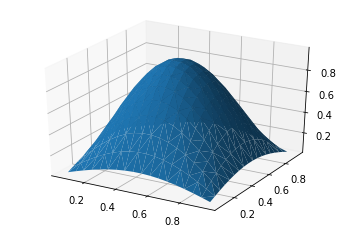

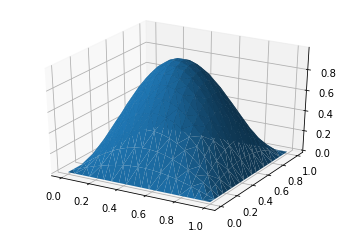

In [4]:
##### 1) Construction de la matrice de raideur élémentaire M_T^A relative à un ELEMENT triangle

# Calcul de l'aire alpha du triangle.

def aire(tri):
    a1 = tri[0,:]
    a2 = tri[1,:]
    a3 = tri[2,:]

    x1,y1 = a1
    x2,y2 = a2
    x3,y3 = a3

    dete = np.array([[x2-x1, x3-x1],[y2-y1, y3-y1]])
    return np.linalg.det(dete)



def raideur(tri):

   M = np.zeros((3,3))
   alpha = aire(tri)

   for i in range (3):
       delta_i = 1/alpha*np.array([tri[(i+1)%3][1]-tri[(i+2)%3][1], tri[(i+2)%3][0]-tri[(i+1)%3][0]])
       for j in range(3):
           delta_j = 1/alpha*np.array([tri[(j+1)%3][1]-tri[(j+2)%3][1], tri[(j+2)%3][0]-tri[(j+1)%3][0]])
           M[i,j] = alpha/2*np.dot(delta_i,delta_j)
   return M




##### 2) Assemblage de la matrice A (maillage d'éléments triangles)

def assemblage(coord,elem3) :
    Ns = len(coord)
    # Ns² est le nombre de sommets du maillage
    A = np.zeros((Ns,Ns))
    nb_tri = np.size(elem3,0)
    for k in range (nb_tri) :
        ele = elem3[k,:]
        M = raideur(coord[ele])
        for i in range(3):
            for j in range(3):
                A[ele[i],ele[j]] += M[i,j]
    return A




# 3) Assemblage du second membre sous conditions de Dirichlet

def f(x,y):
    # On utilise l'expression de f donnée à l'équation 8
    return 2*(np.pi)**2*np.sin(np.pi*x)*np.sin(np.pi*y)

#show(coord,f(coord[:,0],coord[:,1]))

def u_d(x,y):
    # On utilise l'expression de f donnée à l'équation 8
    return np.sin(np.pi*x)*np.sin(np.pi*y)

#show(coord,u_d(coord[:,0],coord[:,1]))

def Ud(coord,dirichlet):
    Ns = len(coord)
    Ud = np.zeros(Ns)

    for i in range(len(dirichlet)):
        Ud[dirichlet[i]] = u_d(coord[dirichlet[i],0],coord[dirichlet[i],1])
    return Ud


# Calcul du second membre b

def second_membre(coord,elem3):
    Ns = len(coord)
    b = np.zeros(Ns)

    nb_tri = np.size(elem3,0)
    for k in range (nb_tri) :
        # on calcule les centres de gravité de chacun des triangles
        tri = elem3[k]

        x_c = np.mean(coord[tri],0)[0]
        y_c = np.mean(coord[tri],0)[1]

        alpha = aire(coord[tri])
        for i in range(3):
            b[tri[i]] += alpha/6*f(x_c,y_c)

    return b
        

# On résout le système en enlevant les conditions de Dirichlet (solution)

def solution(coord,elem3,dirichlet):
    
    A = assemblage(coord,elem3)
    b = second_membre(coord,elem3)
    b -= np.dot(A,Ud(coord,dirichlet))

    # on enlève dans la matrice A les sommets dur la frontière de Dirichlet afin qu'elle soit inversible
    Anew = np.delete(A,dirichlet,0)
    Anew = np.delete(Anew,dirichlet,1)
    bnew = np.delete(b,dirichlet)
    
    x = np.linalg.solve(Anew,bnew)
    return x


# On rajoute les conditions de Dirichlet pour déterminer la solution finale.

def solution_finale(coord,elem3,dirichlet):
    Ns =len(coord)
    ind = np.setdiff1d(range(Ns),dirichlet)

    x = solution(coord,elem3,dirichlet)
    U = Ud(coord,dirichlet)
    x_finale = np.zeros(Ns)
    for i in range(len(ind)):
        x_finale[ind[i]] = x[i]

    x_finale[dirichlet] = U[dirichlet]

    return x_finale


## Affichage :

n=20
coord,elem3,dirichlet,neumann = maillage_carre(n)
coord_bis = np.delete(coord,dirichlet,0)

print("solution :")
print(solution(coord,elem3,dirichlet))
show(coord_bis,solution(coord,elem3,dirichlet))
show(coord,solution_finale(coord,elem3,dirichlet))



**Partie II : maillage mixte et ajoût des conditions de Neumann**

In [5]:
############################# Maillage mixte ################
e3=np.array([[1,2,12],[2,3,12],[3,4,14],[4,5,14],[2,15,3],[3,15,4]]).astype(int)  # éléments des triangles
e4=np.array([[0,1,12,11],[11,12,13,10],[12,3,14,13],[10,13,8,9],[13,14,7,8],[14,5,6,7]]).astype(int)  # éléments des quadrangles
dds=np.array([2,15,4,6,7,8,9,10,11,0]).astype(int)  # tableau des points de Dirichlet
nns=np.array([[4,5],[5,6],[0,1],[1,2]]).astype(int)  # tableau des arêtes de Neumann
ccs=np.array([[0.,0.],[0.33333333333333,0],[0.53333333333333,0.],
                      [0.66666666666667,0.33333333333333],[1.,0.47],[1,0.66666666666667],
                     [1.,1.],[0.66666666666667,1.],[0.33333333333333,1.], [0.,1.],
                     [0.,0.66666666666667],[0.,0.33333333333333],[0.33333333333333,0.33333333333333],
                     [0.33333333333333,0.66666666666667],[0.66666666666667,0.66666666666667],[1.,0.]]) # tableau des coordonnées

solution :
[1.19745734 1.07563635 1.19496015 1.10685927 1.0777467  1.10614464]


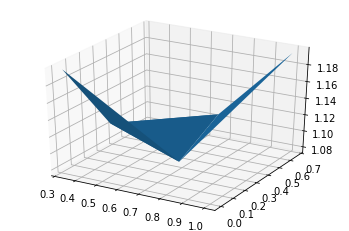

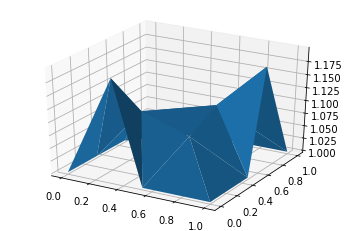

In [6]:
##### 1) Construction de la matrice de raideur élémentaire

# Calcul de la matrice jacobienne liée à un quadrangle

def jacobien(quadr):
    x = quadr[:,0]
    y = quadr[:,1]
    return np.array([[x[1]-x[0],x[3]-x[0]],[y[1]-y[0],y[3]-y[0]]])

# Calcul de la matrice de raideur

def raideur_quadr(quadr):
    # M est une matrice 4x4 / quadr est une matrice 4x2
    M = np.zeros((4,4))
    J = jacobien(quadr)
    [[a, b],[b, c]] = np.linalg.inv(np.dot(np.transpose(J),J))
    
    #calcul des intégrales à la main
    #coefficients diagonaux
    M[0,0] = 2*a+3*b+2*c
    M[1,1] = 2*a-3*b+2*c
    M[2,2] = 2*a+3*b+2*c
    M[3,3] = 2*a-3*b+2*c

    # on calcule les coefficients en utilisant le fait que M soit symétrique
    M[0,1] = -2*a+c
    M[1,0] = M[0,1]

    M[0,2] = -a-3*b-c
    M[2,0] = M[0,2]

    M[0,3] = a-2*c
    M[3,0] = M[0,3]

    M[1,2] = a-2*c
    M[2,1] = M[1,2]

    M[1,3] = -a+3*b-c
    M[3,1] = M[1,3]

    M[2,3] = -2*a+c
    M[3,2] = M[2,3]

    M = (np.linalg.det(J)/6)*M

    return M


##### QUESTION :

## Les valeurs des coefficients de la matrice M érits précédemment sont calculés avec la formule suivante :
## M_ij = integral_[0;1] gradient(phi_i)^T *[a b; b c] * gradient(phi_j) dx.
## avec phi_1(x,y) = (1-x)*(1-y), phi_2(x,y) = x*(1-y)), phi_3(x,y) = xy et phi_4(x,y) = (1-x)*y.


    

##### 2) Assemblage de la matrice A (maillage d'éléments quadrangles)

def assemblage_quadr(coord,elem4):
    Ns = np.size(coord,0)
    # Ns**2 est le nombre de sommets du maillage
    A = np.zeros((Ns,Ns))
    nb_quadr = np.size(elem4,0)
    for k in range (nb_quadr):
        ele = elem4[k,:]
        M = raideur_quadr(coord[ele])
        for i in range(4):
            for j in range(4):
                A[ele[i],ele[j]] += M[i,j]
    return A



##### 3) Inclusion du traitement de tels  ́el ́ements de type Q1 et des conditions de Neumann

def f(x,y):
    return 1


# fonction utilisée pour les conditions de Neumann
def g(x,y):
    return 1


def u_d(x,y):
    return 1


def Ud_quadr(dirichlet,coord):
    Ns = np.size(coord,0)
    Ud = np.zeros(Ns)
    for i in range(len(dirichlet)):
        Ud[dirichlet[i]] = u_d(coord[dirichlet[i],0],coord[dirichlet[i],1])
    return Ud


# Calcul du second membre b

def second_membre_quadr(coord,elem4):
    Ns = np.size(coord,0)
    b = np.zeros(Ns)

    nb_quadr = np.size(elem4,0)
    for k in range (nb_quadr) :
        # on calcule les centres de gravité de chacun des quadrangles
        quadr = elem4[k,:]

        x_c = np.mean(coord[quadr],0)[0]
        y_c = np.mean(coord[quadr],0)[1]

        tri = [quadr[0],quadr[1],quadr[2]]

        alpha = aire(coord[tri])
        for i in range(4):
            b[quadr[i]] += alpha/4*f(x_c,y_c)

    return b


# on calcule cette fois là le terme correspondant aux conditions de Neumann
def neumann_quadr(coord,neumann):
    b = np.zeros(len(coord))
    nb_points = np.size(neumann,0)
    for i in range(nb_points):
        a1 = neumann[i,0]
        a2 = neumann[i,1]
        [x1,y1] = coord[a1]
        [x2,y2] = coord[a2]

        res = np.linalg.norm(coord[a1]-coord[a2])/2*g((x1+x2)/2,(y1+y2)/2)
        b[a1] += res
        b[a2] += res

    return b


# Résolution du système sans les conditions de Dirichlet mais avec les conditions de Neumann

def solution_quadr(coord,elem3,elem4,neumann,dirichlet):
    
    A = assemblage_quadr(coord,elem4) + assemblage(coord,elem3)
    
    b = second_membre_quadr(coord,elem4) + second_membre(coord,elem3)
    
    b -= np.dot(A,Ud_quadr(dirichlet,coord))
    
    # conditions Neumann 
    b += neumann_quadr(coord,neumann)

    # on enlève dans la matrice A les sommets dur la frontière de Dirichlet afin qu'elle soit inversible
    Anew = np.delete(A,dirichlet,0)
    Anew = np.delete(Anew,dirichlet,1)
    bnew = np.delete(b,dirichlet,0)
    x = np.linalg.solve(Anew,bnew)
    return x


# Calcul de la solution finale avec les conditions de Dirichlet

def solution_finale_quadr(coord,elem3,elem4,neumann,dirichlet):
    Ns = len(coord)
    ind = np.setdiff1d(range(Ns),dirichlet)

    x = solution_quadr(coord,elem3,elem4,neumann,dirichlet)
    U = Ud_quadr(dirichlet,coord)
    x_finale = np.zeros(Ns)
    for i in range(len(ind)):
        x_finale[ind[i]] = x[i]

    x_finale[dirichlet] = U[dirichlet]

    return x_finale


## Affichage :

print("solution :")
print(solution_quadr(ccs,e3,e4,nns,dds))
ccs_bis = np.delete(ccs,dds,0)
show(ccs_bis,solution_quadr(ccs,e3,e4,nns,dds))
show(ccs,solution_finale_quadr(ccs,e3,e4,nns,dds))



**Compléments d'analyse du système**

2.089400640117756


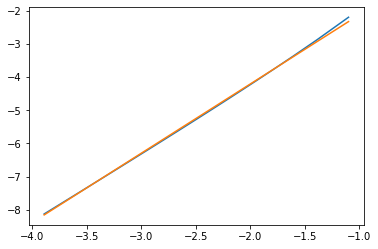

In [7]:
## Analyse de l’ordre du schéma de discrétisation dans le cas d’éléments Triangle


def f(x,y):
    # On utilise l'expression de f donnée à l'équation 8
    return 2*(np.pi)**2*np.sin(np.pi*x)*np.sin(np.pi*y)

def u_d(x,y):
    return 0

def u_ex(x,y):
    # On utilise l'expression de f donnée à l'équation 8
    return np.sin(np.pi*x)*np.sin(np.pi*y)

h_list = []
norm_list = []

for i in range(3,50):
    coord,elem3,dirichlet,neumann = maillage_carre(i)
    u_h = solution_finale(coord,elem3,dirichlet)
    u_ex_h = u_ex(coord[:,0],coord[:,1])
    h = np.sqrt(1/len(u_h-u_ex_h))
    norm = h*np.linalg.norm(u_h-u_ex_h)
    h_list.append(h)
    norm_list.append(norm)


#print(norm_list)
plt.plot(np.log(h_list),np.log(norm_list))

# régression linéaire qui approxime l'évolution de l'erreur
coeff = np.polyfit(np.log(h_list),np.log(norm_list),1)
f = np.poly1d(coeff)
plt.plot(np.log(h_list),f(np.log(h_list)))

print(coeff[0])  # coefficient directeur de la régression linéaire et ordonnée à l'origine


#### QUESTION :

## Le coefficient directeur obtenu vaut environ 2. Il s'agit de l'ordre de la discrétisation.



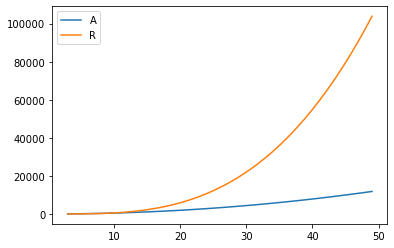

In [12]:
## Résolution du système linéaire par une méthode directe

N_A = [] # liste des zéros de A
N_R = [] # liste des zéros de R

for i in range(3,50):
    coord,elem3,dirichlet,neumann = maillage_carre(i)

    A = assemblage(coord,elem3)
    Anew = np.delete(A,dirichlet,0)
    Anew = np.delete(Anew,dirichlet,1)
    nb_zeros_A = np.where(A!=0)[0]
    N_A.append(len(nb_zeros_A))

    R = np.linalg.cholesky(Anew)  # méthode de Cholesky
    nb_zeros_R = np.where(R!=0)[0]
    N_R.append(len(nb_zeros_R))


## Affichage du nombre d'éléments non nuls de A et R
plt.plot(range(3,50),N_A, label ='A')
plt.plot(range(3,50),N_R, label = 'R')
plt.legend()


############## QUESTIONS :

## On affiche le nombre d'éléments non nuls de R (et de A). On remarque que le nombre d'éléments non nuls explose
## quand la taille de la matrice augmente (ici variant de 3 à 50).

## Le comportement mis en évidence est donc que la place en mémoire prise par R devient de plus en plus grande
## quand la taille du maillage (et donc de la matrice R) augmente.

## Afin de réduire le coût mémoire de cette factorisation de Cholesky, on pourrait manipuler des matrices 
## creuses (plutôt que pleines) afin de ne pas avoir à stocker tous les zéros de la matrice L (et A) en 
## particulier quand elle est de grande dimension.




